# Lecture 07: Determining a Pathway to Fast Charge
---
## Motivation
A goal for modern electric vehicles is to have the effective charge rate match that of refueling a gas tank. What is required from both the charger and the battery to get this done?

We'll use some back of the envelope estimate and dualfoil to determine what engineering pathway might get us there.

In [1]:
import sys
sys.path.append("/pithy/code")
from pithy import *
import dualfoil
import sympy
%matplotlib inline

## The Charger
When we pump gasoline into a tank, how do we get an equivalent charge rate?

Let's take the energy density of gasoline, and assume a 2 minute fill up for a 16 gallon tank.

In [2]:
from sympy.physics.units import *
gallon = 3.78541*liter
ed_gasoline = 1.3e8 *J/gallon
fill_time = 120 * second
tank_size = 16 * gallon
power_req = ed_gasoline * tank_size/fill_time
megawatt = 1e6*watt
rate = convert_to(power_req,megawatt)
pump_to_wheels = .2
print "Fuel Power:",rate,', Effective Power',pump_to_wheels*rate

Fuel Power: 17333333.3333333*watt , Effective Power 3466666.66666667*watt


This is a rate of charge of 17 **MW**. Even assuming a pump to wheels efficiency of 20%, this is ~3.5MW from a single charge station. 

By way of comparison, a level three charger is currently ~80 **kW**. So this charging infrastructure is a non-trivial step beyond where we are now.

Let's take a look at the battery

## The Battery

So how do we determine what configuration of battery might get us to such an effective charge rate?

Let's first take the standard configuration in dualfoil, discharge it at a slow rate (to determine maximum capacity), and then charge it at a rate that should get us to two minutes to fill.

In [3]:
#instantiate simulator
df = dualfoil.dualfoil("user")

In [4]:
rate = 1 #A/m^2
df.clear_cycles()
df.set_current(rate,10000000,minv=3.2) #discharge at i A/m^2 for until we hit cutoff minv
df.writeOut()
df.runDualFoil(debug=False,output=True,force=False) #don't force dualfoil to run, show realtime output

0

In [5]:
data = df.readOutput()
discharge_time = max(data['t'])-min(data['t'])
discharge_time 

1416.8969999999999

So, in order to find a rate that gets us to 2 minutes full up:

In [6]:
target_time = 2.0
fast_rate = rate*discharge_time/target_time

Now, let's rebuild a cycling protocol to test this out

In [7]:
df.clear_cycles()
df.set_current(rate,10000000,minv=3.2) #discharge at i A/m^2 for until we hit cutoff minv
df.set_current(0,10,minv=3.2) #relax
df.set_current(-1*fast_rate,100000000,maxv=4.4) #negative rates = charge
df.writeOut()
df.runDualFoil(debug=False,output=True,force=False) #don't force dualfoil to run, show realtime output

0

Upon charging at 708.45 A/m^2 we used 10.72% of the battery


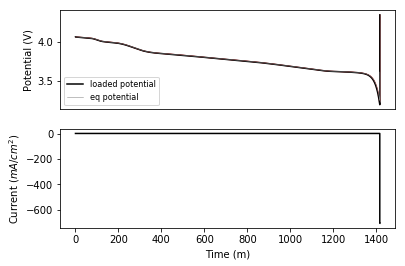

In [8]:
data = df.readOutput()
x_done = min(data['nutil']) #the anode state when discharged
y_done = max(data['putil']) #the cathode state when discharged
se_1 = data['se']
utilization = abs(data['se'][-1]/data['se'][0])

print "Upon charging at %.2f A/m^2 we used %.2f%% of the battery" %(fast_rate,100*utilization)
df.ivtplot(ir_emph=True)

As we can see from the figure above and the utilization calculation, this battery is really quite impeding at the rate required to fill the cell up in two minutes. As a guess, let's try to reduce the thickness of the electrodes to encourage a faster charge. In the script below, we'll run the simulation twice in one go to get the full capacity and then set the charge rate

Upon charging at 34.11 A/m^2 we used 73.94% of the battery


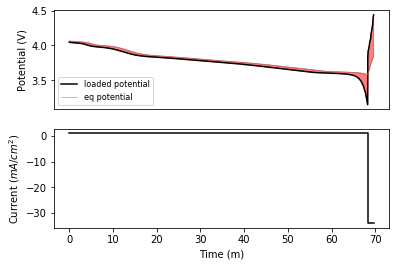

In [9]:
#make the battery electrodes thinner, match on original ratio
th_ratio = float(df.parts['h3'].replace("d","e"))/float(df.parts['h1'].replace("d","e"))
df.parts['h1'] = 5.0e-6 #microns
df.parts['h3'] = df.parts['h1']*th_ratio #microns

df.clear_cycles()
df.set_current(rate,10000000,minv=3.2) #discharge at i A/m^2 for until we hit cutoff minv
df.writeOut()
df.runDualFoil(debug=False,output=True,force=False) #don't force dualfoil to run, show realtime output
data = df.readOutput()
x_done = min(data['nutil']) #the anode state when discharged
y_done = max(data['putil']) #the cathode state when discharged
discharge_time = max(data['t'])-min(data['t'])

target_time = 2.0
fast_rate = rate*discharge_time/target_time

df.clear_cycles()
df.set_current(rate,10000000,minv=3.2) #discharge at i A/m^2 for until we hit cutoff minv
df.set_current(0,10,minv=3.2) #relax
df.set_current(-1*fast_rate,100000000,maxv=4.4) #negative rates = charge
df.writeOut()
df.runDualFoil(debug=False,output=True,force=False) #don't force dualfoil to run, show realtime output
data = df.readOutput()

utilization = abs(data['se'][-1]/data['se'][0])

print "Upon charging at %.2f A/m^2 we used %.2f%% of the battery" %(fast_rate,100*utilization)
df.ivtplot(ir_emph=True)


So, we now get close to a 2 minute charge, and a further reduction in thickness might do it, but the cost is pretty high: let's look at our energy density

In [10]:
se_2 = data['se']
print 'Battery 1: %.2f Wh/kg, Battery 2: %.2f Wh/kg' % (se_1[0],se_2[0])
print 'Battery 2/Battery 1 Energy Density = %.2f%% ' % (100*se_2[0]/se_1[0])

Battery 1: 109.27 Wh/kg, Battery 2: 12.24 Wh/kg
Battery 2/Battery 1 Energy Density = 11.20% 


So if we just reduce electrode thickness, we take a **90%** hit on energy density! So we have to do something else. Let's try changing the size of the particles in the matrices

Upon charging at 709.87 A/m^2 we used 24.84% of the battery


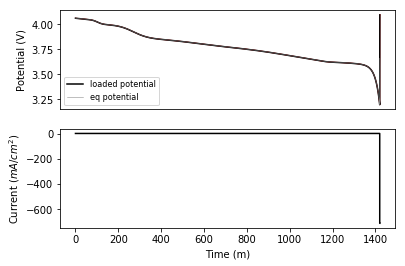

Battery 1: 109.27 Wh/kg, Battery 3: 109.52 Wh/kg
Battery 3/Battery 1 Energy Density = 100.23% 


In [11]:
#make the battery electrodes thick again, match on original ratio
df.parts['h1'] = 100.0e-6 #microns
df.parts['h3'] = df.parts['h1']*th_ratio #microns


#now let's mess with particle size
df.parts['Rad1'] = 1e-9
df.parts['Rad3'] = 1e-9

df.clear_cycles()
df.set_current(rate,10000000,minv=3.2) #discharge at i A/m^2 for until we hit cutoff minv
df.writeOut()
df.runDualFoil(debug=False,output=True,force=False) #don't force dualfoil to run, show realtime output
data = df.readOutput()
x_done = min(data['nutil']) #the anode state when discharged
y_done = max(data['putil']) #the cathode state when discharged
discharge_time = max(data['t'])-min(data['t'])

target_time = 2.0
fast_rate = rate*discharge_time/target_time

df.clear_cycles()
df.set_current(rate,10000000,minv=3.2) #discharge at i A/m^2 for until we hit cutoff minv
df.set_current(0,10,minv=3.2) #relax
df.set_current(-1*fast_rate,100000000,maxv=4.4) #negative rates = charge
df.writeOut()
df.runDualFoil(debug=False,output=True,force=False) #don't force dualfoil to run, show realtime output
data = df.readOutput()

se_3 = data['se']
utilization = abs(se_3[-1]/se_3[0])

print "Upon charging at %.2f A/m^2 we used %.2f%% of the battery" %(fast_rate,100*utilization)
df.ivtplot(ir_emph=True)

print 'Battery 1: %.2f Wh/kg, Battery 3: %.2f Wh/kg' % (se_1[0],se_3[0])
print 'Battery 3/Battery 1 Energy Density = %.2f%% ' % (100*se_3[0]/se_1[0])


Nanostructuring helps, but isn't good enough to increase charge rate and as we'll learn in later lectures with increased surface area comes other problems.

Might we have to alter the material itself? Let's adjust the diffusion coefficients and see what happens.

Upon charging at 283.94 A/m^2 we used 40.14% of the battery


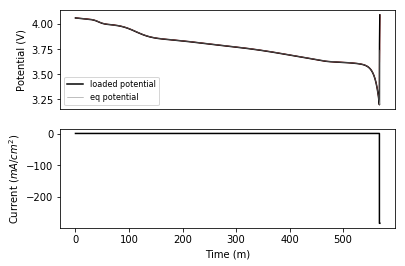

Battery 1: 109.27 Wh/kg, Battery 4: 72.04 Wh/kg
Battery 4/Battery 1 Energy Density = 65.93% 


In [12]:
#make the battery electrodes thick again, match on original ratio
df.parts['h1'] = 30.0e-6 #microns
df.parts['h3'] = df.parts['h1']*th_ratio #microns

#now let's mess with particle size
df.parts['Rad1'] = 100e-9
df.parts['Rad3'] = 100e-9

#Now try porosity
df.parts['ep1'] = .1 
df.parts['ep3'] = .1 


#now let's mess with diffusion coefficient
df.parts['dfs1'] = 1e-10
df.parts['dfs3'] = 1e-10



df.clear_cycles()
df.set_current(rate,10000000,minv=3.2) #discharge at i A/m^2 for until we hit cutoff minv
df.writeOut()
df.runDualFoil(debug=False,output=True,force=False) #don't force dualfoil to run, show realtime output
data = df.readOutput()
x_done = min(data['nutil']) #the anode state when discharged
y_done = max(data['putil']) #the cathode state when discharged
discharge_time = max(data['t'])-min(data['t'])

target_time = 2.0
fast_rate = rate*discharge_time/target_time

df.clear_cycles()
df.set_current(rate,10000000,minv=3.2) #discharge at i A/m^2 for until we hit cutoff minv
df.set_current(0,10,minv=3.2) #relax
df.set_current(-1*fast_rate,100000000,maxv=4.4) #negative rates = charge
df.writeOut()
df.runDualFoil(debug=False,output=True,force=False) #don't force dualfoil to run, show realtime output
data = df.readOutput()

se_4 = data['se']
utilization = abs(se_4[-1]/se_4[0])

print "Upon charging at %.2f A/m^2 we used %.2f%% of the battery" %(fast_rate,100*utilization)
df.ivtplot(ir_emph=True)

print 'Battery 1: %.2f Wh/kg, Battery 4: %.2f Wh/kg' % (se_1[0],se_4[0])
print 'Battery 4/Battery 1 Energy Density = %.2f%% ' % (100*se_4[0]/se_1[0])


So we're still not there, but we see that as we change various material and geometric parameters we can kinda/sorta hone in at a point that is close.

But there are a huge number of caveats, and we should be clear that **as of 2018-04-05** a battery does not exist that provides the energy density sufficient for an electric vehicle. There is still much work to be done. 

There are still many parameters that can be adjusted above..... but remember, if dualfoil cannot do it, there's a strong chance it is not possible, as we are not accounting for

- Cycle Life
- Calendar
- Temperature
- Cell Effects
- Safety


   Time     Util N  Util P  Cell Pot   Uocp      Curr      Temp   heatgen
   (min)       x       y      (V)       (V)      (A/m2)    (C)    (W/m2)
    5.090, 0.5906, 0.5052,  4.01109,  4.05790,   100.00,  24.85,   3.83, 
    5.090, 0.5906, 0.5052,  4.01109,  4.05790,   100.00,  24.85,   3.83, 
    9.515, 0.1317, 0.7610,  3.53947,  3.64529,   100.00,  24.85,  12.62, 
   10.732, 0.0281, 0.8188,  3.53305,  3.55041,     0.00,  24.85,   1.02, 
  



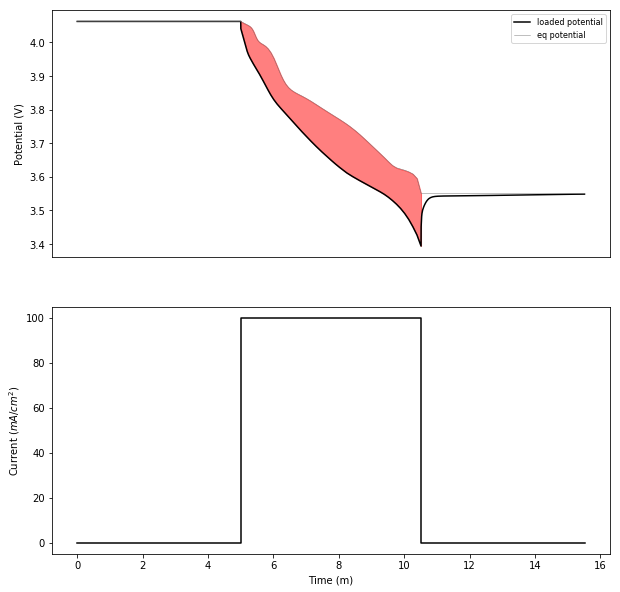

In [16]:
figure(figsize=(10,10))
df.clear_cycles()
df.set_current(0*rate,5,minv=3.4) #discharge at i A/m^2 for until we hit cutoff minv
df.set_current(100*rate,10000000,minv=3.4) #discharge at i A/m^2 for until we hit cutoff minv
df.set_current(0*rate,5,minv=3.4) #discharge at i A/m^2 for until we hit cutoff minv
df.writeOut()
df.runDualFoil(debug=False,output=True,force=False) #don't force dualfoil to run, show realtime output
data = df.readOutput()
df.ivtplot(ir_emph=True)
